# MNIST

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
items = get_image_files(path)

Example item

In [5]:
items[0]

Path('/home/waydegg/.fastai/data/mnist_png/training/0/8147.png')

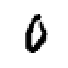

In [7]:
im = PILImageBW.create(items[0])
im.show()

Split data into train and valid sets. We will be using `GrandparentSplitter` which looks at the folder names the data is already in.

In [10]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')

In [13]:
splits = splits(items)

In [16]:
splits[0][:5], splits[1][:5]

([0, 1, 2, 3, 4], [60000, 60001, 60002, 60003, 60004])

In [23]:
items[0]

Path('/home/waydegg/.fastai/data/mnist_png/training/0/8147.png')

In [22]:
parent_label(items[60003])

'0'

In [24]:
?Categorize

Now, we can use the low-level `Datasets` object to create the dataset that will eventually be used in a `Dataloader` that our model takes in.

First, we specify all of our un-split *items*.

Then, we apply "transforms". These transforms are the steps needed to get our X and y data into their proper formats for reading them in. In this case, for our images we're calling `PILImageBW.create` to load in our images, and for our labels we (1) call `parent_label`, which just gets the label of the folder directly above the item, and then (2) call `Categorize`, which makes everything into categories for classification. 

Finaly, we pass in how we split the data.


In [17]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], splits=splits)

In [25]:
dsrc

(#70000) [(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0))...]

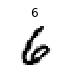

In [33]:
# an example of training data in our dataset
show_at(dsrc.train, 11135)

Time to define some *item transforms*. These are applied from left to right on all items before training.

In [35]:
item_tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

In [36]:
batch_tfms = [IntToFloatTensor(), Normalize()]

In [37]:
dls = dsrc.dataloaders(bs=128, after_item=item_tfms, after_batch=batch_tfms)

In [ ]:
dsrc.dataloaders()

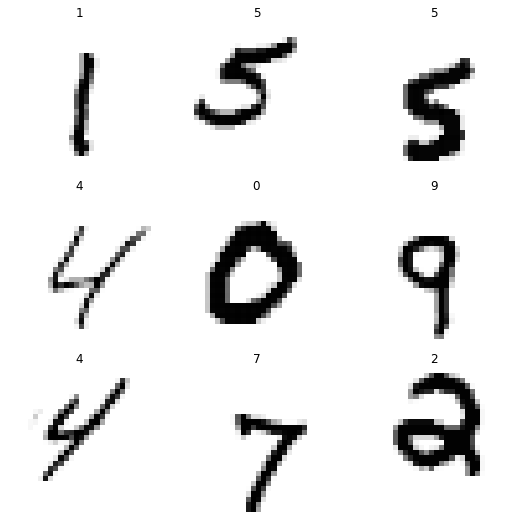

In [41]:
dls.show_batch()

Look at some of the dataset attributes

In [42]:
xb, yb = dls.one_batch()

Input shape of \[128x1x28x28] and the output shape will be a \[128] tensor that we need to condense into 10 classes

In [43]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [44]:
dls.c # number of unique classes

10

**The Model**

`ni` is the number of inputs, and `nf` is the number of filters.

In [45]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

`nf` is the number of filters from the preceding convolutional layer.

In [46]:
def bn(nf): return nn.BatchNorm2d(nf)

In [47]:
def ReLU(): return nn.ReLU(inplace=False)

At the end of the model we will use `Flatten()` which turns the preceding layer outputs into a 1-D Tensor.

In [49]:
??Flatten

In [48]:
model = nn.Sequential(
    conv(1,8),
    bn(8),
    ReLU(),
    conv(8,16),
    bn(16),
    ReLU(),
    conv(16,32),
    bn(32),
    ReLU(),
    conv(32,16),
    bn(16),
    ReLU(),
    conv(16,10),
    bn(10),
    Flatten()
)

Define a `Learner`. Must at least have a dataloader, a model, and a loss function.

In [54]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [51]:
learn.summary()

Sequential (Input shape: ['128 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 8 x 14 x 14    80         True      
________________________________________________________________
BatchNorm2d          128 x 8 x 14 x 14    16         True      
________________________________________________________________
ReLU                 128 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               128 x 16 x 7 x 7     1,168      True      
________________________________________________________________
BatchNorm2d          128 x 16 x 7 x 7     32         True      
________________________________________________________________
ReLU                 128 x 16 x 7 x 7     0          False     
________________________________________________________________
Conv2d               128 x 32 x 4 x 4     4,640      True      
__________________________________________________

(0.33113112449646, 0.3019951581954956)

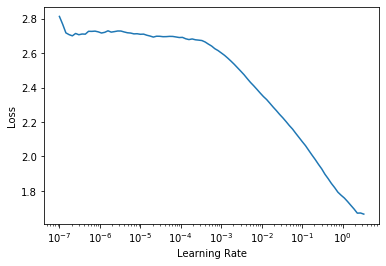

In [52]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.154089,0.273508,0.914100,00:10
1,0.136523,0.114463,0.964100,00:11
2,0.102531,0.070281,0.978200,00:11
3,0.066328,0.035242,0.988800,00:11
4,0.051343,0.027958,0.990000,00:11


Simplifying our model

In [56]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

In [60]:
net = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

In [65]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [66]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.228313,0.297766,0.909500,00:09
1,0.130612,0.069469,0.978000,00:09
2,0.073731,0.040766,0.987500,00:09


Resnet-ish Model

In [67]:
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf)
        self.conv2 = ConvLayer(nf, nf)
    
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

In [69]:
net = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

In [70]:
net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

Even simpler model

In [71]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [72]:
net = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

In [73]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

(0.13182567358016967, 0.43651583790779114)

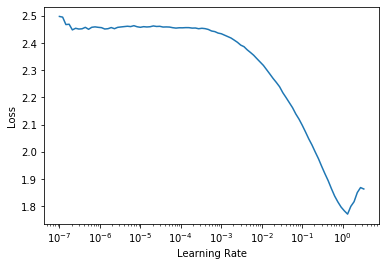

In [74]:
learn.lr_find()

In [75]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.150143,0.124934,0.963000,00:12
1,0.084433,0.056795,0.982400,00:12
2,0.039652,0.023523,0.992900,00:12


# SGD

In [1]:
from fastai2.basics import *

In [2]:
n = 100
x = torch.ones(n, 2) # 100 x 2 tensor

In [3]:
x[:,0].uniform_(-1.,1) # random value from -1 to 1, in place
x[:5], x.shape

(tensor([[ 0.1028,  1.0000],
         [-0.0491,  1.0000],
         [-0.8979,  1.0000],
         [-0.3196,  1.0000],
         [ 0.1404,  1.0000]]),
 torch.Size([100, 2]))

In [4]:
# example point
m = tensor(3., 2); m, m.shape

(tensor([3., 2.]), torch.Size([2]))

In [5]:
# random bias
b = torch.rand(n); b[:5], b.shape

(tensor([0.2077, 0.6131, 0.1272, 0.3752, 0.2655]), torch.Size([100]))

In [6]:
# make our y
y = x@m + b

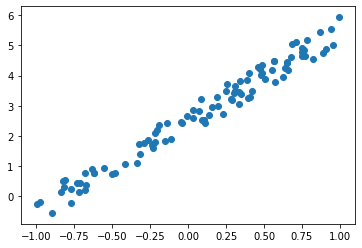

In [10]:
plt.scatter(x[:,0],y)

In [22]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

When we run our model, we are trying to predict `m`.

For example, lets look at `a`. 

1. Make a prediction
2. Calculate the error

In [18]:
a = tensor(.5, .75)

In [19]:
y_pred = x@a

In [23]:
mse(y_pred,y)

tensor(5.8392)

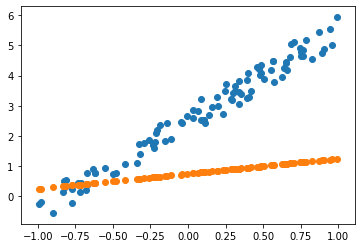

In [24]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_pred)

**Walking Down Gradient Descent**

Goal: minimize the loss function (mse in our case)

In [25]:
a = nn.Parameter(a); a

Parameter containing:
tensor([0.5000, 0.7500], requires_grad=True)

In [26]:
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if i % 10 == 0:
        print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [27]:
lr = 1e-1

In [28]:
for i in range(100):
    update()

tensor(5.8392, grad_fn=<MeanBackward0>)
tensor(0.5552, grad_fn=<MeanBackward0>)
tensor(0.2064, grad_fn=<MeanBackward0>)
tensor(0.1144, grad_fn=<MeanBackward0>)
tensor(0.0866, grad_fn=<MeanBackward0>)
tensor(0.0782, grad_fn=<MeanBackward0>)
tensor(0.0757, grad_fn=<MeanBackward0>)
tensor(0.0749, grad_fn=<MeanBackward0>)
tensor(0.0747, grad_fn=<MeanBackward0>)
tensor(0.0746, grad_fn=<MeanBackward0>)


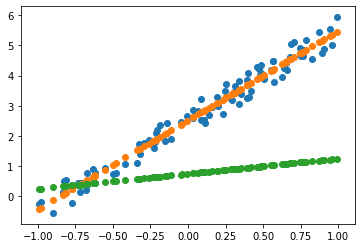

In [29]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0], (x@a).detach())
plt.scatter(x[:,0],y_pred)

Animate the process

In [30]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [31]:
a = nn.Parameter(tensor(0.5,0.75))
a

Parameter containing:
tensor([0.5000, 0.7500], requires_grad=True)

In [35]:
def animate(i):
    update()
    line.set_ydata((x@a).detach())
    return line,

In [38]:
fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], (x@a).detach())
plt.close()

In [39]:
animation.FuncAnimation(fig, animate, np.arange(0,100), interval=20)